In [1]:
#importing necessary packages 

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from prophet import Prophet
from tqdm import tqdm

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
#Loading the csv file into dataframes

prices = pd.read_csv('opening_prices.csv', index_col='date')

prices.index = pd.DatetimeIndex(prices.index)

prices = prices.to_period('B').sort_index()

In [3]:
prices.head()

,open
date,
2010-01-01,12.36
2010-01-04,12.36
2010-01-05,12.47
2010-01-06,12.75
2010-01-07,12.83


In [4]:
#Converting the dataframe to a pandas series
prices_series = prices['open']
prices_series

date
2010-01-01    12.36
2010-01-04    12.36
2010-01-05    12.47
2010-01-06    12.75
2010-01-07    12.83
              ...  
2017-12-21    51.16
2017-12-22    51.05
2017-12-27    51.45
2017-12-28    51.65
2017-12-29    51.76
Freq: B, Name: open, Length: 2044, dtype: float64

# Preprocessing

We use TimeSeriesSplit() to do cross-validation while respecting the time order of the data. We make a plot to visualize the train-test split for each cross validation fold.

LEN OF TRAIN_INDEX: 344 LEN OF TEST_INDEX: 340
LEN OF TRAIN_INDEX: 684 LEN OF TEST_INDEX: 340
LEN OF TRAIN_INDEX: 1024 LEN OF TEST_INDEX: 340
LEN OF TRAIN_INDEX: 1364 LEN OF TEST_INDEX: 340
LEN OF TRAIN_INDEX: 1704 LEN OF TEST_INDEX: 340


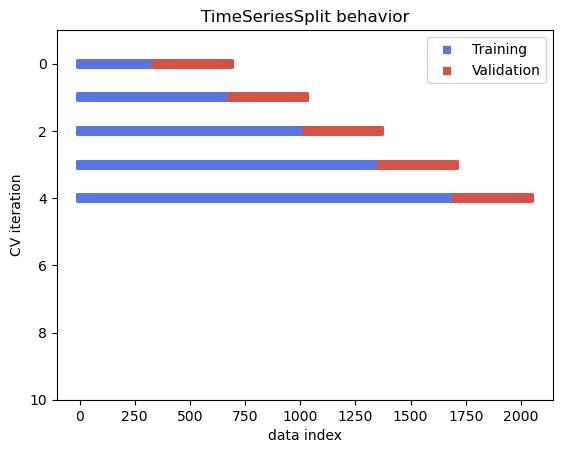

In [5]:
tscv = TimeSeriesSplit()

fig, ax = plt.subplots()
for ii, (train_index, test_index) in enumerate(tscv.split(prices_series)):
    print("LEN OF TRAIN_INDEX:", len(train_index), "LEN OF TEST_INDEX:", len(test_index))
    l1 = ax.scatter(train_index, [ii] * len(train_index), c=[plt.cm.coolwarm(.1)],
                   marker='_', lw=6)
    l2 = ax.scatter(test_index, [ii] * len(test_index), c=[plt.cm.coolwarm(.9)],
                   marker='_', lw=6)
    ax.set(ylim=[10,-1], title='TimeSeriesSplit behavior', xlabel='data index', 
           ylabel='CV iteration')
    ax.legend([l1,l2], ['Training', 'Validation'])

# Modeling

## ARIMA model

First, we do a hyperparameter search over the ARIMA parameters (p,d=1,q) with 5-fold cross-validation. We start by writing a function which computes the mean cross-validation MAPE score for a given choice of p and q.

Note that we set d=1 because we have seen from the Data Wrangling notebook that the stock prices are not a stationary time series, but the first difference (i.e. the returns) is stationary.

In [6]:
def cv_score(p,q):

    scores_list = []

    for ii, (train_index, test_index) in enumerate(tscv.split(prices)):
        train, test = list(tscv.split(prices))[ii][0], list(tscv.split(prices))[ii][1]
        model = ARIMA(prices_series[train], order=(p,1,q))
        results = model.fit()
        prediction = results.predict(test[0],test[-1])
        score = MAPE(prices_series[test], prediction)
        scores_list.append(score)
    
    return sum(scores_list)/len(scores_list)

Then, we scan over a range of values of p and q and print out the mean MAPE score for each of them.

In [7]:
MAPE_score_dict = {}

for p in range(3):
    for q in range(3):
        MAPE_score_dict[(p,q)] = cv_score(p,q)
        print("p = ", p, ", q = ", q, ", mean MAPE score: ", cv_score(p,q))

/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p =  0 , q =  0 , mean MAPE score:  0.15526851359151878
p =  0 , q =  1 , mean MAPE score:  0.15521659637740076
p =  0 , q =  2 , mean MAPE score:  0.15529932401295218
p =  1 , q =  0 , mean MAPE score:  0.15520364558445693


/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

p =  1 , q =  1 , mean MAPE score:  0.15516422452477444
p =  1 , q =  2 , mean MAPE score:  0.15535232892792078
p =  2 , q =  0 , mean MAPE score:  0.1552569669563942


/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

p =  2 , q =  1 , mean MAPE score:  0.15526398061921118


/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to

p =  2 , q =  2 , mean MAPE score:  0.15173029227914586


In [8]:
#The smallest mean MAPE score is:
min_MAPE = min(MAPE_score_dict.values())
min_MAPE

0.15173029227914586

In [9]:
#The value of p and q corresponding to the smallest MAPE score is:
best_p_q = list(MAPE_score_dict.keys())[list(MAPE_score_dict.values()).index(min_MAPE)]
best_p_q

(2, 2)

/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/phucnguyen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


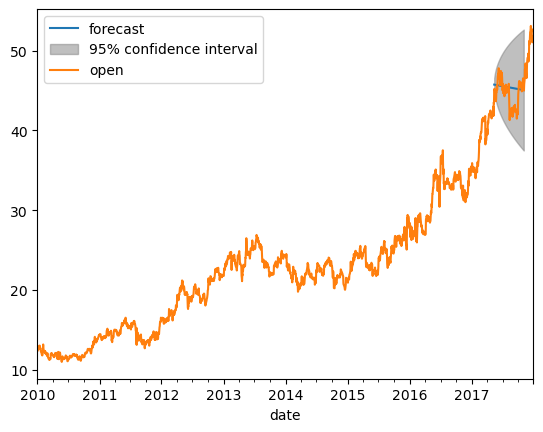

In [10]:
#Choosing p and q to be the best values, and making a plot of the forecast.
fig, ax = plt.subplots()
res = ARIMA(prices_series[:1920], order=(2,0,2)).fit()
plot_predict(res, start=1920, end=2044, ax=ax)
prices.plot(ax=ax)
plt.show()

## Exponential smoothing 

Next, we use Simple Exponential Smoothing. We apply cross-validation in the same way as we did for the ARIMA model:

In [11]:
scores_list = []

for ii, (train_index, test_index) in enumerate(tscv.split(prices)):
        train, test = list(tscv.split(prices))[ii][0], list(tscv.split(prices))[ii][1]
        model = SimpleExpSmoothing(prices_series[train])
        results = model.fit()
        prediction = results.predict(test[0],test[-1])
        score = MAPE(prices_series[test], prediction)
        scores_list.append(score)

The mean cross-validation score is:

In [12]:
print(sum(scores_list)/len(scores_list))

0.15523009393135917


## Facebook prophet

In [75]:
scores_list = []

for ii, (train_index, test_index) in tqdm(enumerate(tscv.split(prices))):
        train, test = list(tscv.split(prices))[ii][0], list(tscv.split(prices))[ii][1]
        model = Prophet()
        df = prices_series[train].to_frame().reset_index().rename(columns={"date":"ds","open":"y"})
        df['ds'] = df['ds'].dt.to_timestamp()
        results = model.fit(df)
        future = model.make_future_dataframe(periods=len(test), freq='D')
        prediction = results.predict(future)
        score = MAPE(prices_series[test], prediction[len(train):]['yhat'])
        scores_list.append(score)

0it [00:00, ?it/s]22:19:21 - cmdstanpy - INFO - Chain [1] start processing
22:19:21 - cmdstanpy - INFO - Chain [1] done processing
1it [00:00,  2.56it/s]22:19:21 - cmdstanpy - INFO - Chain [1] start processing
22:19:21 - cmdstanpy - INFO - Chain [1] done processing
2it [00:00,  1.94it/s]22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing
3it [00:01,  1.47it/s]22:19:23 - cmdstanpy - INFO - Chain [1] start processing
22:19:23 - cmdstanpy - INFO - Chain [1] done processing
4it [00:03,  1.10it/s]22:19:24 - cmdstanpy - INFO - Chain [1] start processing
22:19:25 - cmdstanpy - INFO - Chain [1] done processing
5it [00:04,  1.14it/s]


In [77]:
print(sum(scores_list)/len(scores_list))

0.10459194155739997
